# Building and Experimenting with Facial Recognition and the VGG Deep Face CNN Model
I spent the better part of 3 weeks working on this project, and by no means is it a cakewalk. To complete the effort, you will need time, patience, and access to a bunch of GPUs and a super computer. It's kind of funny to me that sometimes Nishant, the author of our reading, will casually throw out some possible applications of what you learned at the end of each chapter. Sometimes they are hard, sometimes easy, but when he threw out the [VGG Face Dataset](http://www.robots.ox.ac.uk/~vgg/data/vgg_face/) and how it could be used for facial recognition, and after doing the [CIFAR-10 Notebook](http://localhost:8888/notebooks/Listing%209.17-ex9.3.ipynb) in Listing 9.17-example 9.3, I figured I could handle anything. Furthermore, extrapolating from CIFAR-10 to facial recognition wasn't that hard. Instead of predicting 10 classes e.g., `airplane, bird, frog`, etc., we would be predicting `2622` classes of celebrities, like `Zoe Saldana` or `Betty White`. Seemed simple enough.

Wow, what was I thinking? This assignment requires you to:

   0. Take a bunch of independent text files with URLs and combine them together somehow. I parsed them using Pandas data frames and created one big data frame and saved it in `vgg_face_full.csv`.
   1. Download over millions of images from URLs, many of which are broken since the [original paper](http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf) - btw, necessary reading in full to do this assignment! - was published at British Machine Vision in 2015. To correct this, I spent nearly 2 weeks - due to the sheer size and time required to validate and check URLs and all the errors with them - using Pandas Data Frames, adding a new feature called `VALID_URL` - and figuring out of the original 2622 * 1000 = 2.62M image urls, that only around 1.25M of them were actually still valid URLs, a further, smaller subset of them were actually images, since a `VALID_URL` is one thing, but the question of whether it is actually an image, or a 404 page etc was very much in play. Most of the early part of the notebook is getting to an actual dataset I could download. To create the test URL valid set, I had to write a separate python program, `vgg_valid_url.py` and end up using multiprocessing.Pool and map reduce to parallelize the URL checks since checking 2.6M URLs is a pain on any system and due to timeouts, etc., and all the problems with crawling the web, doing it sequentially takes expotentially longer. I ended up with success on a 48 core machine with n=48 proc for multiprocessing and splitting the 2.6M URLs into 54k chunks to check.
   2. After getting a valid URL dataset, I wrote a program separate of this notebook called `vgg_create_img.py` to take the valid URLs from the pandas data frame CSV I made called `vgg_face_full_urls.csv` and download them in parallel. This took days. It was more than downloading the images from the URLs, it was dealing with all the not a valid image, and other errors that arose during the downloading process, as I alluded to before. I also had to [read a tutorial](https://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python) on how to take an image and a bounding box, and crop out using OpenCV Python, the actual face from that image. I'm not talking automatically I'll get to that in a bit - but just simply taking a given bounding box, which VGG Face gives you, and then cropping it into a new image of size `244x244` which is the size of the input for the VGG Face Network I was going to construct. Saving the images after downloading them as the newly cropped face of course took time, and there are interesting variances in the color scale of the images, I can best attribute to the fact I used PNG, some of the URLs were greyscale (after later inspection) and I didn't force everything into 3 channel RGB and just assumed they all were (bad assumption that can be fixed in the future). To collect all of the 1.25M URLs as face cropped images (for the successful URLs that were actually images), I had to use a supercomputer, parallelize things, and have `~90Gb` of space available for the uncompressed dataset. The yield from the process was a folder, `vgg-face` with 2622 celebrity names e.g., `Paul_Sorvino` at the top level directories, and inside of each directory, a file named `N_244x244.png` where `N` was the `df.reset()` index number result after reindexing after subsetting to just the valid URLs, and ultimately where `N` was between `1` and on average `~477` samples per class.
   3. Then the _real_ fun began. So, I have all this image data. How to construct a dataset from it? I ended up reading a ton of tutorials, in particular [this excellent one from the Tensorflow folks on building a dataset from images](https://www.tensorflow.org/tutorials/load_data/images) and I got exposed to the [Tensorflow Dataset API](https://www.tensorflow.org/guide/datasets). This is the big buff way to construct datasets, with cool things such as auto epoch `repeat()` functions on the DS so you don't have to do explicit epochs, you can just repeat the dataset. Auto `shuffle()` function. And I finally could take advantage of all of the cool [CIFAR-10 Tensorflow Image Manipulation I saw](https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10_input.py#L58) when doing the CIFAR-10 tutorial. So I was able to build a TF Dataset of Randomly Cropped, Noised, and Flipped Images and use TF.Dataset API and its ability to generate `one_shot_iterator()` pipelines to create batches of images and associated labels automatically from disks to train on a subset of the VGG Face data. I concluded that I only really could do about 4 celebrities overall, especially since I wanted to get the training started on my local laptop. Batch size was an important selection, I was able to do `BATCH_SIZE=256` on my local laptop, but when I took this to a supercomputer with lots of GPUs the GPUs ran out of memory with that `BATCH_SIZE` and I ended up having to use `BATCH_SIZE=64` to get it running there. The tradeoff was fine as progress was reported more often and the GPU sped everything up. The 4 celebrities I picked for the training all fit the mean of `~477 images per sample`. After training on two different supercomputers for over a day, one of them progress to ~500 epochs out of 1000 and I achieved (at present) a `70% Micro-ROC average` on the four classes `Betty_White, Kate_Beckinsale, Paul_Sorvino, Zoe_Saldana`. My further goal is to extend this to support all `2622` celebrities, but that will require more time on the supecomputer.
   4. To evaluate and generate the ROC curve, I curated my own set of 10 usable image URLs that face cropped well using Google Image Search for `Betty_White`, `Kate_Beckinsale`, `Paul_Sorvino` and `Zoe Saldana`. So I created a `40x244x244x3` test data set, and associated `40x1` label set, and then I cache and save them as `.npy` files so you don't have to generate them again after the first time.
   
## References

   1. [VGG Face Dataset README](http://www.robots.ox.ac.uk/~vgg/data/vgg_face/README)
   2. [Tensorflow Dataset Load Images and Labels Tutorial](https://www.tensorflow.org/tutorials/load_data/images)
   3. [Face Cropping from Images Automatically with OpenCV](https://www.programcreek.com/python/example/71301/cv2.imread)
   4. [How to use the Tensorflow Dataset API](https://medium.com/ymedialabs-innovation/how-to-use-dataset-and-iterators-in-tensorflow-with-code-samples-3bb98b6b74ab)
   5. [Error when loading Images with Tensorflow about wrong format PNG/JPG/etc.](https://github.com/tensorflow/tensorflow/issues/13583) - I had Mac hidden files get transferred up with the dataset to the supercomputer and needed this to figure out what was going on.
   6. [Another great Tensorflow Dataset Tutorial](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428)
   7. [Important Bug when moving from Mac to Supercomputer and diff Matplotlib versions](https://github.com/matplotlib/matplotlib/pull/10220). This bug arose since older versions of Matplotlib would let you provide RGB images (e.g., those noised up from Tensorflow augmentation transformations) whose data ranges for RGB were outside of the normal 0..1 range - newer versions throw an error and you have to account for it by doing `image = np.abs(image / np.max(image))`. Also described [here](https://github.com/matplotlib/matplotlib/issues/10372).
   8. [Replace explicit set up of training epochs with Dataset.repeat in Tensorflow](https://stackoverflow.com/questions/47067401/how-to-iterate-dataset-several-times-using-tensorflow-dataset-api). 
   9. [Tensorflow Dataset Class](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
   10. [Face Detection using OpenCV](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)
   11. [Simple Bounding Boxes on Kaggle](https://www.kaggle.com/alekseit/simple-bounding-boxes)
   12. [Object Detection and Bounding Boxes using MXNet](https://www.d2l.ai/chapter_computer-vision/bounding-box.html)
   13. [Rename Columns in Pandas Dataframe](https://stackoverflow.com/questions/19523277/renaming-column-names-in-pandas-groupby-function)
   14. [Balancing Columns in Pandas Dataframes](https://stackoverflow.com/questions/45839316/pandas-balancing-data)
   15. [Dataframe Plot Bars](https://www.geeksforgeeks.org/python-pandas-dataframe-plot-bar/)
   16. [Pandas Aggregation and Grouping](https://data36.com/pandas-tutorial-2-aggregation-and-grouping/)
   17. [Pandas Map Reduce / Apply Progress Function](https://towardsdatascience.com/make-your-own-super-pandas-using-multiproc-1c04f41944a1) - critical to understand how to parallelize functions over data frames. Also see [df.apply()](https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.DataFrame.apply.html). Also see [this issue](https://github.com/pandas-dev/pandas/issues/14964).
   18. [Pandas Data Frame Progress during Functions using TQDM](https://stackoverflow.com/questions/18603270/progress-indicator-during-pandas-operations).
   19. [Large Celeb Faces Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).
   20. [Efficiently check URLs and their validity in Python](https://stackoverflow.com/questions/42150697/efficiently-check-millions-of-image-urls-in-python) - motiviation for using multiprocessing.Pool.
   21. [Facenet](https://github.com/davidsandberg/facenet/tree/master/src) - Literally someone already implemented something analogous to VGG-Face. I may run it later. They implemented a similar download VGG Face script to the one I wrote. Interestingly this also shows you how to implement triplet-loss but it was a little advanced for me so didn't really get it. Also see [this](https://programtalk.com/vs2/?source=python/2964/facenet/src/facenet_train.py).
   22. [Tuning the performance of Tensorflow Datasets via the TF.Dataset API](https://www.tensorflow.org/guide/performance/datasets)
   23. [How to split humongous files on the Mac](https://superuser.com/questions/362177/how-to-split-big-files-on-mac) - needed this for the tarball of VGG Face. Also see [this](https://apple.stackexchange.com/questions/218242/how-can-i-split-a-60-gb-file-into-5-gb-pieces-on-a-mac). 
   

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib.patches import Rectangle
import cv2
from skimage import color
from skimage.io import imread
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from tqdm.auto import tqdm as tqdm_nn
import random
import requests
from requests.exceptions import ConnectionError
from requests.exceptions import ReadTimeout
import pathlib
import IPython.display as display
from tensorflow.data.experimental import AUTOTUNE 
import tensorflow.contrib.eager as tfe
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
import glob

In [2]:
IMAGE_SIZE=244
BATCH_SIZE=64 # on PRP, needed to switch this to 64 to fit into GPU memory and not run out of resources

In [3]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
 
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [4]:
def clip_image(url, bbox):
    image = imread(url)
    
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    
    w=x2-x1
    h=y2-y1
    
    crop_img = image[y1:y1+h, x1:x1+w]
    new_size = IMAGE_SIZE, IMAGE_SIZE
    crop_img = cv2.resize(crop_img, new_size, interpolation=cv2.INTER_CUBIC)
    plt.figure()
    plt.imshow(crop_img)

In [5]:
def bbox_on_img(url, bbox):
    image = imread(url)
    plt.figure()
    plt.imshow(image)
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    
    w=x2-x1
    h=y2-y1
    rect = Rectangle((x1, y1), w, h, fill=False, color='r')
    plt.axes().add_patch(rect)
    plt.show()   

In [6]:
def process_celeb(name, path):
    # format is 
    # Each line represents:
    # id url left top right bottom pose detection_score curation
    # id: Integer id for an image 
    # url: The weblink for the image. 
    # [left top right bottom] the bounding box for an image. 
    # pose: frontal/profile (pose>2 signifies a frontal face while
    # pose<=2 represents left and right profile detection).
    # detection score: Score of a DPM detector.
    # curation: Whether this image was a part of final curated dataset
    
    df = pd.read_csv(path, sep=' ', names=['ID', 'URL', 'LEFT', 'TOP', 'RIGHT', 'BOTTOM', 'POSE', 'DETECTION', 'CURATION'])
    celeb_list = [name] * len(df)
    df['CELEB'] = celeb_list
    return df
        

In [7]:
def get_celeb_box(df, name, img_num):
    the_box_row = df.loc[df['CELEB']==name]
    the_box_row = the_box_row.iloc[img_num]
    return the_box_row[['LEFT', 'TOP', 'RIGHT', 'BOTTOM']].values

In [8]:
def get_celeb_url(df, name, img_num):
    the_url_row = df.loc[df['CELEB']==name].iloc[img_num]['URL']
    return the_url_row

In [9]:
def url_ok(url):
    try:
        r = requests.head(url, timeout=timeout)
        return r.status_code == 200
    except (ConnectionError, ReadTimeout)  as e:
        #print("URL connection error", url)
        return False

In [10]:
def image_and_clip_from_url_auto(url):
    image = imread(url)
      # Converting to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    haar_cascade_face = cv2.CascadeClassifier('/usr/local/Cellar/opencv/4.1.0_2/share/opencv4/haarcascades/haarcascade_frontalface_default.xml')
    faces_rects = haar_cascade_face.detectMultiScale(image_gray, scaleFactor = 1.5, minNeighbors = 5);

    # Let us print the no. of faces found
    print('Faces found: ', len(faces_rects))
    print('Rects: ', faces_rects)

    plt.figure()
    plt.imshow(image)
    
    for i in range(0, len(faces_rects)):     
        rect = Rectangle((faces_rects[i][0], faces_rects[i][1]), faces_rects[i][2], faces_rects[i][3], fill=False, color='r')
        plt.axes().add_patch(rect)
        
    plt.show() 

In [11]:
def get_clip_image(url, bbox):
    image = imread(url)
    
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    
    w=x2-x1
    h=y2-y1
    
    crop_img = image[y1:y1+h, x1:x1+w]
    new_size = IMAGE_SIZE, IMAGE_SIZE
    crop_img = cv2.resize(crop_img, new_size, interpolation=cv2.INTER_CUBIC)
    #crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
    return crop_img

In [12]:
def get_image_and_clip_from_url_auto(url):
    image = imread(url)
      # Converting to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    haar_cascade_face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces_rects = haar_cascade_face.detectMultiScale(image_gray, scaleFactor = 1.5, minNeighbors = 5);

    # Let us print the no. of faces found
    print('Faces found: ', len(faces_rects))
    print('Rects: ', faces_rects)

    if len(faces_rects) > 0:
        # grab the inner one
        face_rect = faces_rects[len(faces_rects)-1]
        x1 = face_rect[0]
        y1 = face_rect[1]
        w = face_rect[2]
        h = face_rect[3]
        
        crop_img = image[y1:y1+h, x1:x1+w]
        new_size = IMAGE_SIZE, IMAGE_SIZE
        crop_img = cv2.resize(crop_img, new_size, interpolation=cv2.INTER_CUBIC)
        #crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
        return crop_img 
    else:
        return image

In [13]:
valid_face_urls_path = 'vgg_face_full_urls.csv'
face_urls_path = 'vgg_face_full.csv'

if not os.path.exists(valid_face_urls_path):  
    path = 'vgg_face_dataset/files'
    for (dirpath, dirnames, filenames) in os.walk(path):
        df = None
        for filename in tqdm(filenames):
            if filename.endswith('.txt'): 
                celeb_name = os.path.splitext(filename)[0]
                full_path = os.sep.join([dirpath, filename])
                #print("Processing: ["+celeb_name+"]: full path: ["+full_path+"]")
                if df is not None:
                    df = df.append(process_celeb(celeb_name,  full_path))
                else:
                    df = process_celeb(celeb_name, full_path)
    
    df.to_csv(face_urls_path)
    print('Num Celeb Images', str(len(df)))
else:
    # run the script vgg_valid_url.py and change n_cores to how many parallel proc you want validating the URLs
    # running this script will yield a new dataframe saved in the file that you are opening below with a new 
    # column, VALID_URL set to True if the result of requests.head(url, timeout=0.0001) is 200, else False
    df = pd.read_csv(valid_face_urls_path)    

In [14]:
num_valid_urls = str(len(df[df.VALID_URL==True]))
num_invalid_urls = str(len(df[df.VALID_URL==False]))
print('Num valid URLs', num_valid_urls)
print('Num invalid URLs', num_invalid_urls)

Num valid URLs 1252215
Num invalid URLs 1352634


In [15]:
df = df[df.VALID_URL==True]

In [16]:
print('Size new DF only valid URLs', str(len(df)))

Size new DF only valid URLs 1252215


In [17]:
celeb_names = df.CELEB.unique()
print(celeb_names)
print(str(len(celeb_names)))

['Hailee_Steinfeld' 'William_Powell' 'Zachary_Quinto' ...
 'Jean_Louisa_Kelly' 'Jennifer_Finnigan' 'Ashley_Jones']
2622


Random Celeb Troye_Sivan
Random Pic Num 47
[57.49 57.49 160.05 160.05]
http://3.bp.blogspot.com/-0Ke75b7sbGw/UgOesT-GE8I/AAAAAAAAtY4/3pwwpKdTu-Y/s1600/Troye+Sivan+5962887.png


/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


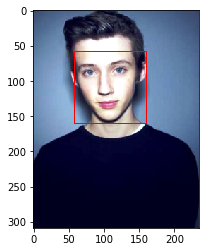

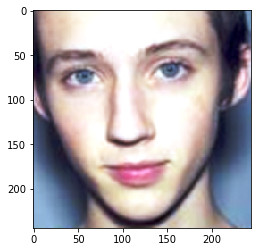

In [18]:
rand_celeb = random.randint(0, len(celeb_names))
rand_pic_num = random.randint(0, 50) # top 50 pics
celeb_name = celeb_names[rand_celeb]
c_num = rand_pic_num

print('Random Celeb', celeb_name)
print('Random Pic Num', str(c_num))

c_box =  get_celeb_box(df, celeb_name, c_num)
print(c_box)
c_url= get_celeb_url(df, celeb_name, c_num)
print(c_url)

bbox_on_img(c_url, c_box)
clip_image(c_url, c_box)

In [19]:
df.head()

,Unnamed: 0,Unnamed: 0.1,ID,URL,LEFT,TOP,RIGHT,BOTTOM,POSE,DETECTION,CURATION,CELEB,VALID_URL
0,0,0,1,http://ethnicelebs.com/wp-content/uploads/2011...,93.19,111.76,260.00,278.58,3.0,4.01,1,Hailee_Steinfeld,True
1,1,1,2,http://media3.onsugar.com/files/2012/09/38/4/1...,184.79,184.79,514.62,514.62,3.0,4.07,1,Hailee_Steinfeld,True
3,3,3,4,http://www.teenidols4you.com/blink/Actors/hail...,169.90,127.67,358.91,316.68,4.0,4.08,1,Hailee_Steinfeld,True
4,4,4,5,http://img2.timeinc.net/instyle/images/2011/aw...,78.98,156.95,311.90,389.88,4.0,3.79,1,Hailee_Steinfeld,True
5,5,5,6,http://www3.pictures.zimbio.com/gi/Hailee%252B...,73.85,147.37,294.07,367.58,3.0,4.62,1,Hailee_Steinfeld,True


In [20]:
plot_df = df.groupby('CELEB').count()[['URL']]
plot_df.head()

,URL
CELEB,
A.J._Buckley,550
A.R._Rahman,434
A_P_J_Abdul_Kalam,165
Aamir_Khan,375
Aaron_Staton,536


In [21]:
plot_df.mean()

URL    477.580092
dtype: float64

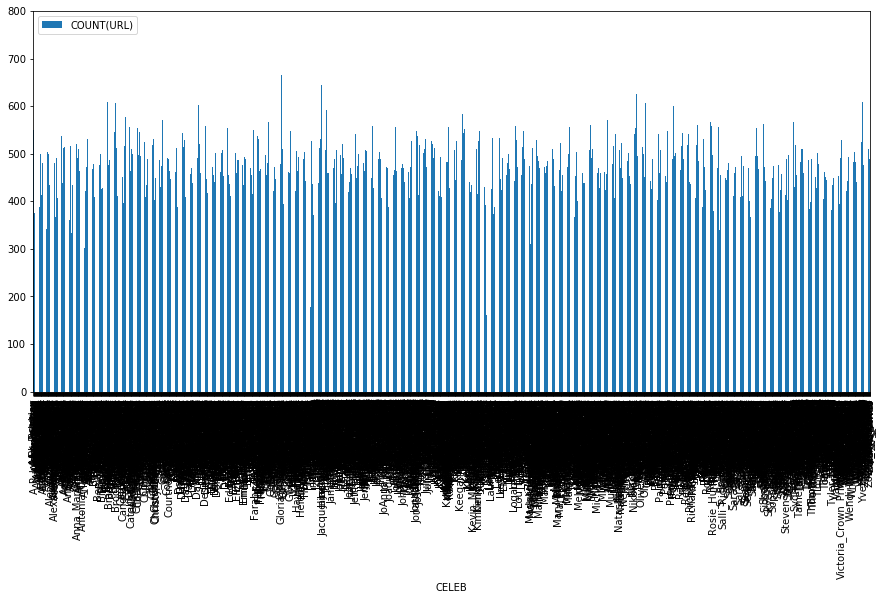

In [22]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xticklabels(df.index)
plot_df = plot_df.rename(columns={'URL':'COUNT(URL)'})
plot_df.plot.bar(ax=ax)

In [23]:
df.reset_index(inplace=True)

In [24]:
df.head()

,index,Unnamed: 0,Unnamed: 0.1,ID,URL,LEFT,TOP,RIGHT,BOTTOM,POSE,DETECTION,CURATION,CELEB,VALID_URL
0,0,0,0,1,http://ethnicelebs.com/wp-content/uploads/2011...,93.19,111.76,260.00,278.58,3.0,4.01,1,Hailee_Steinfeld,True
1,1,1,1,2,http://media3.onsugar.com/files/2012/09/38/4/1...,184.79,184.79,514.62,514.62,3.0,4.07,1,Hailee_Steinfeld,True
2,3,3,3,4,http://www.teenidols4you.com/blink/Actors/hail...,169.90,127.67,358.91,316.68,4.0,4.08,1,Hailee_Steinfeld,True
3,4,4,4,5,http://img2.timeinc.net/instyle/images/2011/aw...,78.98,156.95,311.90,389.88,4.0,3.79,1,Hailee_Steinfeld,True
4,5,5,5,6,http://www3.pictures.zimbio.com/gi/Hailee%252B...,73.85,147.37,294.07,367.58,3.0,4.62,1,Hailee_Steinfeld,True


In [25]:
df.index

RangeIndex(start=0, stop=1252215, step=1)

In [26]:
data_root_orig = 'vgg-face'
data_root = pathlib.Path(data_root_orig)

In [27]:
for item in data_root.iterdir():
    print(item)

vgg-face/Betty_White
vgg-face/Kate_Beckinsale
vgg-face/Paul_Sorvino
vgg-face/Zoe_Saldana


In [28]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

1903

In [29]:
all_image_paths[:10]

['vgg-face/Zoe_Saldana/438_244x244.png',
 'vgg-face/Betty_White/303_244x244.png',
 'vgg-face/Paul_Sorvino/29_244x244.png',
 'vgg-face/Paul_Sorvino/374_244x244.png',
 'vgg-face/Betty_White/850_244x244.png',
 'vgg-face/Betty_White/870_244x244.png',
 'vgg-face/Kate_Beckinsale/318_244x244.png',
 'vgg-face/Zoe_Saldana/815_244x244.png',
 'vgg-face/Paul_Sorvino/775_244x244.png',
 'vgg-face/Betty_White/643_244x244.png']

In [30]:
def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image  " + ' - ' + str(pathlib.Path(image_path).parent).split('/')[1]

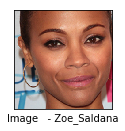

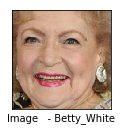

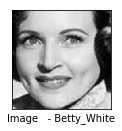

In [31]:
plt.figure()
for n in range(3):
    plt.subplot(2,2,n+1)
    image_path = random.choice(all_image_paths)
    im = imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    plt.imshow(im)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(image_path))
    plt.show()

In [32]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Betty_White', 'Kate_Beckinsale', 'Paul_Sorvino', 'Zoe_Saldana']

In [33]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Betty_White': 0, 'Kate_Beckinsale': 1, 'Paul_Sorvino': 2, 'Zoe_Saldana': 3}

In [34]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])
print('First 10 image paths: ', all_image_paths[:10])

First 10 labels indices:  [3, 0, 2, 2, 0, 0, 1, 3, 2, 0]
First 10 image paths:  ['vgg-face/Zoe_Saldana/438_244x244.png', 'vgg-face/Betty_White/303_244x244.png', 'vgg-face/Paul_Sorvino/29_244x244.png', 'vgg-face/Paul_Sorvino/374_244x244.png', 'vgg-face/Betty_White/850_244x244.png', 'vgg-face/Betty_White/870_244x244.png', 'vgg-face/Kate_Beckinsale/318_244x244.png', 'vgg-face/Zoe_Saldana/815_244x244.png', 'vgg-face/Paul_Sorvino/775_244x244.png', 'vgg-face/Betty_White/643_244x244.png']


In [35]:
def preprocess_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = image[..., ::-1] # images are stored on files with these reversed, so fix per https://stackoverflow.com/questions/42161916/tensorflow-how-to-switch-channels-of-a-tensor-from-rgb-to-bgr  
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    # Randomly flip the image horizontally.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=63)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    
    # Fixed standardization 
    image = (tf.cast(image, tf.float32) - 127.5)/128.0
    # Subtract off the mean and divide by the variance of the pixels.
    image = tf.image.per_image_standardization(image)

    return image

In [36]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

W0807 05:59:25.627999 140251368433472 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1514: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0807 05:59:26.442037 140251368433472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


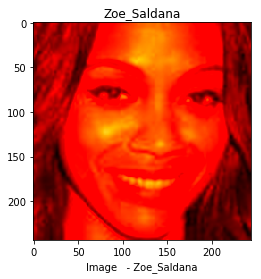

In [37]:
img_path = all_image_paths[0]
label = all_image_labels[0]

with tf.Session() as sess:
    im = sess.run(load_and_preprocess_image(img_path))
    #plt.imshow(cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
    plt.imshow(im)
    plt.grid(False)
    plt.xlabel(str(caption_image(img_path)))
    plt.title(label_names[label].title())
    print()

In [38]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [39]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

W0807 05:59:27.101243 140251368433472 deprecation.py:323] From <ipython-input-39-2a9400bc986b>:1: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0807 05:59:27.103311 140251368433472 deprecation.py:323] From <ipython-input-39-2a9400bc986b>:2: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [40]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

W0807 05:59:27.839738 140251368433472 deprecation.py:323] From <ipython-input-41-42b6fe050e2f>:3: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0807 05:59:28.094045 140251368433472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


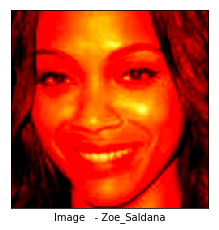

W0807 05:59:28.182141 140251368433472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


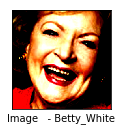

W0807 05:59:28.225516 140251368433472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


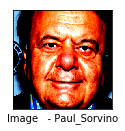

W0807 05:59:28.270774 140251368433472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


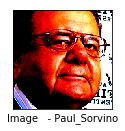

In [41]:
with tf.Session() as sess:
    plt.figure(figsize=(8,8))
    iterator = image_ds.make_one_shot_iterator()
    next_element = iterator.get_next()

    n=0
    for i in range(4):
        image = sess.run(next_element)
        plt.subplot(2,2,n+1)
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(caption_image(all_image_paths[n]))
        plt.show()
        n = n + 1

In [42]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [43]:
with tf.Session() as sess:
    iterator = label_ds.make_one_shot_iterator()
    next_element = iterator.get_next()

    for i in range(4):
        label = sess.run(next_element)
        print(label_names[label])


Zoe_Saldana
Betty_White
Paul_Sorvino
Paul_Sorvino


In [44]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [45]:
print(image_label_ds)

<DatasetV1Adapter shapes: ((244, 244, 3), ()), types: (tf.float32, tf.int64)>


In [46]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((244, 244, 3), ()), types: (tf.float32, tf.int32)>

In [47]:
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 244, 244, 3), (?,)), types: (tf.float32, tf.int32)>

In [48]:
shuffle_test = True
use_bgr = False

In [49]:
white_test = ['https://cdn.aarp.net/content/dam/aarp/entertainment/celebrities/2018/01/1140-betty-white-long-life.imgcache.reve3cb55327d97aae2fe0480129cb5deaf.jpg',
              'https://cdn.cptv.org/wp-content/uploads/2018/08/20181644/Betty-White.jpeg',
              'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/gettyimages-71599564-1547664650.jpg',
              'https://www.usmagazine.com/wp-content/uploads/2019/01/betty-white-97th-birthday.jpg',
              'https://nyppagesix.files.wordpress.com/2018/07/betty-white-los-angeles-zoo.jpg?quality=90&strip=all&w=618&h=410&crop=1',
              'https://media1.popsugar-assets.com/files/thumbor/fOXXn2gES-ILuPjqkj9z4XozKBw/fit-in/1024x1024/filters:format_auto-!!-:strip_icc-!!-/2019/01/17/829/n/1922153/93f28e885c40cf4aab03c2.46321495_/i/Betty-White-Beauty-Looks.jpg',
              'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/betty-white-during-48th-golden-apple-awards-at-beverly-news-photo-105176093-1546282323.jpg',
              'https://thenypost.files.wordpress.com/2018/08/tsdgogi_ec057.jpg?quality=90&strip=all&w=618&h=410&crop=1',
              'https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fimg1.southernliving.timeinc.net%2Fsites%2Fdefault%2Ffiles%2Fstyles%2F4_3_horizontal_-_1200x900%2Fpublic%2F1515194788%2FGettyImages-141306780.jpg%3Fitok%3Dq0eB9rIn%261515194853&w=400&c=sc&poi=face&q=85',
              'https://www.gannett-cdn.com/presto/2018/08/18/USAT/5df674bc-d767-43f7-addc-28e6ea3805a1-Betty_White.JPG?crop=2999,1721,x0,y337&width=3200&height=1680&fit=bounds'
             ]
beck_test =  ['https://m.media-amazon.com/images/M/MV5BMTM3MzY2MDYwOF5BMl5BanBnXkFtZTcwODQ3MDA0Nw@@._V1_.jpg',
              'https://a57.foxnews.com/media2.foxnews.com/BrightCove/694940094001/2019/06/21/931/524/694940094001_6050925461001_6050926599001-vs.jpg?ve=1&tl=1',
              'https://a57.foxnews.com/media2.foxnews.com/BrightCove/694940094001/2019/07/05/931/524/694940094001_6055918630001_6055921541001-vs.jpg?ve=1&tl=1',
              'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/actress-kate-beckinsale-attends-the-2018-vanity-fair-oscar-news-photo-927338684-1550592188.jpg?crop=1.00xw:0.666xh;0,0.0803xh&resize=480:*',
              'https://cdn-img.instyle.com/sites/default/files/images/2019/07/071019-kate-beckinsale-lead.jpg',
              'https://www.wonderwall.com/photos/2019/03/31/1051227-50th-naacp-image-awards-red-carpet.jpg?x=574&y=800&icq=74&sig=ebd0bff9279348ad66152a90e4d6d02f',
              'https://images.amcnetworks.com/bbcamerica.com/wp-content/uploads/2019/04/Kate-Beckinsale-1600x720.jpg',
              'https://s.yimg.com/ny/api/res/1.2/CRnpC8s09avG6Z8s2eMzIg--~A/YXBwaWQ9aGlnaGxhbmRlcjtzbT0xO3c9ODAw/http://media.zenfs.com/en/homerun/feed_manager_auto_publish_494/f5406004c836067aa0c37e7b974fe8ad',
              'https://ca-times.brightspotcdn.com/dims4/default/a1c63fd/2147483647/strip/true/crop/2048x1365+0+0/resize/840x560!/quality/90/?url=https%3A%2F%2Fca-times.brightspotcdn.com%2F6e%2F93%2F377ae54a7550f7075ce246ebf57b%2Fla-1553625268-wyiqk70c5r-snap-image',
              'https://www.gannett-cdn.com/presto/2019/02/10/USAT/224fb527-73d6-432e-b75c-bc6392093f24-GTY_1085422194.JPG?crop=2906,1680,x0,y419&width=3200&height=1680&fit=bounds'
              
             ]


sorvino_test = ['https://akns-images.eonline.com/eol_images/Entire_Site/201803/rs_634x1024-180103101949-634-paul-sorvino.jpg?fit=inside|900:auto&output-quality=90',
                'https://pmcdeadline2.files.wordpress.com/2018/09/paul-sorvino-2.jpg?w=630&h=383&crop=1',
                'https://m.media-amazon.com/images/M/MV5BNWEwOTdiODItMTI3NS00NjNlLThmZGEtNTJiMjhlNDAwOWUwXkEyXkFqcGdeQXVyNzU1NzE3NTg@._V1_CR0,45,480,270_AL_UX477_CR0,0,477,268_AL_.jpg',
                'https://vignette.wikia.nocookie.net/memoryalpha/images/d/de/Nikolai_Rozhenko.jpg/revision/latest?cb=20150217221424&path-prefix=en',
                'https://s.hdnux.com/photos/77/75/23/16766170/3/920x920.jpg',
                'http://ethnicelebs.com/wp-content/uploads/2016/06/bigstock-LOS-ANGELES-MAR-Paul-Sor-121070222-Paul-Sorvino-400x600.jpg',
                'https://fast.clickbooq.com/f915eb-788/Sorvinoplaying002-lg.jpg',
                'https://bloximages.chicago2.vip.townnews.com/madison.com/content/tncms/assets/v3/editorial/6/4e/64eabd1c-fda6-11e5-a85c-2327b45808bb/5707db4869649.image.jpg?resize=500%2C750',
                'http://media.lehighvalleylive.com/movies_impact/photo/paul-sorvino-9a2cbdb4ba5ae0e3.jpg',
                'https://media.gettyimages.com/photos/actor-paul-sorvino-attends-the-143rd-kentucky-derby-at-churchill-on-picture-id679745196?s=612x612'
               ]
saldana_test = ['https://vignette.wikia.nocookie.net/memoryalpha/images/8/87/Zoe_Saldana.jpg/revision/latest?cb=20180209114538&path-prefix=en',
                'https://www.nydailynews.com/resizer/PHK-L5ZhiQ0ZmKLWYZU_TFTwzeU=/800x533/top/arc-anglerfish-arc2-prod-tronc.s3.amazonaws.com/public/VNNQAMWYYBHM3J7AFGBWWTITJ4.jpg',
                'https://www.famousbirthdays.com/faces/saldana-zoe-image.jpg',
                'https://ionemadamenoire.files.wordpress.com/2016/06/zoe-saldana-allure-july-2016-photoshoot-011.jpg',
                'https://scstylecaster.files.wordpress.com/2015/04/187523998.jpg',
                'https://media.wmagazine.com/photos/5acbff7b077f7752d7818943/4:3/w_1536/GettyImages-452657150.jpg',
                'https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fpeopledotcom.files.wordpress.com%2F2016%2F08%2Fzoe-saldana-01-435-1.jpg&w=400&c=sc&poi=face&q=85',
                'https://ewedit.files.wordpress.com/2017/06/sia.jpg',
                'https://www.usmagazine.com/wp-content/uploads/2018/02/zoe-saldana.jpg?w=300',
                'https://vignette.wikia.nocookie.net/stan-lee-cameo/images/8/87/Zoe_Saldana.jpg/revision/latest?cb=20190504115459'
]

In [50]:
test_data = []
test_labels = []
test_names = label_names
    
if os.path.exists('vgg-face-test-data.npy') and os.path.isfile('vgg-face-test-data.npy') and os.path.exists('vgg-face-test-labels.npy') and os.path.isfile('vgg-face-test-labels.npy'):
    print('Loading cached test data and labels.')
    test_data = np.load('vgg-face-test-data.npy')
    test_labels = np.load('vgg-face-test-labels.npy')
    print(np.shape(test_data))
    print(test_labels)

    if shuffle_test:
        print('Shuffling Test/Eval Data.')
        test_data,test_labels = shuffle(test_data, test_labels)
        print(test_labels)

else:
    test_data = []
    test_labels = [label_to_index['Betty_White'] for i in range(0, len(white_test))]
    test_labels += [label_to_index['Kate_Beckinsale'] for i in range(0, len(beck_test))]
    test_labels += [label_to_index['Paul_Sorvino'] for i in range(0, len(sorvino_test))]
    test_labels += [label_to_index['Zoe_Saldana'] for i in range(0, len(saldana_test))]

    for st in white_test:
        cimg = get_image_and_clip_from_url_auto(st)
        cimg = cimg.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
        if len(test_data) > 0:
            test_data = np.vstack((test_data, cimg.astype(np.float32)))
        else:
            test_data = cimg.astype(np.float32)

    for st in beck_test:
        cimg = get_image_and_clip_from_url_auto(st)
        cimg = cimg.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
        if len(test_data) > 0:
            test_data = np.vstack((test_data, cimg.astype(np.float32)))
        else:
            test_data = cimg.astype(np.float32)

    for st in sorvino_test:
        cimg = get_image_and_clip_from_url_auto(st)
        cimg = cimg.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
        if len(test_data) > 0:
            test_data = np.vstack((test_data, cimg.astype(np.float32)))
        else:
            test_data = cimg.astype(np.float32)

    for st in saldana_test:
        cimg = get_image_and_clip_from_url_auto(st)
        cimg = cimg.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
        if len(test_data) > 0:
            test_data = np.vstack((test_data, cimg.astype(np.float32)))
        else:
            test_data = cimg.astype(np.float32)
    
    print(np.shape(test_data))
    print(test_labels)
    np.save('vgg-face-test-data.npy', test_data)
    np.save('vgg-face-test-labels.npy', test_labels)

Loading cached test data and labels.
(40, 244, 244, 3)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]
Shuffling Test/Eval Data.
[1 1 3 2 0 2 0 2 3 2 0 1 1 2 2 1 1 2 0 1 2 1 3 0 3 0 1 0 3 3 3 3 2 3 0 0 2
 1 3 0]


In [51]:
conv1_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 3, 64], mean=0, stddev=10e-2)) # third param is RGB, so 3
conv1_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 64, 64], mean=0, stddev=10e-2)) 
conv2_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 64, 128], mean=0, stddev=10e-2))
conv2_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 128, 128], mean=0, stddev=10e-2))
conv3_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 128, 256], mean=0, stddev=10e-2))
conv3_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 256, 256], mean=0, stddev=10e-2))
conv3_3_filter = tf.Variable(tf.random_normal(shape=[3, 3, 256, 256], mean=0, stddev=10e-2))
conv4_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 256, 512], mean=0, stddev=10e-2))
conv4_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
conv4_3_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
conv5_1_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
conv5_2_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))
conv5_3_filter = tf.Variable(tf.random_normal(shape=[3, 3, 512, 512], mean=0, stddev=10e-2))

In [52]:
def model(x, keep_prob):    
    # 1, 2, 3, 4, 5, 6
    conv1_1 = tf.nn.conv2d(x, conv1_1_filter, strides=[1,1,1,1], padding='SAME')
    conv1_1 = tf.nn.relu(conv1_1)
    conv1_2 = tf.nn.conv2d(conv1_1, conv1_2_filter, strides=[1,1,1,1], padding='SAME')
    conv1_2 = tf.nn.relu(conv1_2)
    conv1_pool = tf.nn.max_pool(conv1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    # 7, 8, 9, 10, 11, 12
    conv2_1 = tf.nn.conv2d(conv1_pool, conv2_1_filter, strides=[1,1,1,1], padding='SAME')
    conv2_1 = tf.nn.relu(conv2_1)
    conv2_2 = tf.nn.conv2d(conv2_1, conv2_2_filter, strides=[1,1,1,1], padding='SAME')
    conv2_2 = tf.nn.relu(conv2_2)
    conv2_pool = tf.nn.max_pool(conv2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
  
    # 13, 14, 15, 16, 17, 18
    conv3_1 = tf.nn.conv2d(conv2_pool, conv3_1_filter, strides=[1,1,1,1], padding='SAME')
    conv3_1 = tf.nn.relu(conv3_1)
    conv3_2 = tf.nn.conv2d(conv3_1, conv3_2_filter, strides=[1,1,1,1], padding='SAME') 
    conv3_2 = tf.nn.relu(conv3_2)
    conv3_3 = tf.nn.conv2d(conv3_2, conv3_3_filter, strides=[1,1,1,1], padding='SAME') 
    conv3_3 = tf.nn.relu(conv3_3)
    conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    
    # 19, 20, 21, 22, 23, 24, 25, 26
    conv4_1 = tf.nn.conv2d(conv3_pool, conv4_1_filter, strides=[1,1,1,1], padding='SAME')
    conv4_1 = tf.nn.relu(conv4_1)
    conv4_2 = tf.nn.conv2d(conv4_1, conv4_2_filter, strides=[1,1,1,1], padding='SAME') 
    conv4_2 = tf.nn.relu(conv4_2)
    conv4_3 = tf.nn.conv2d(conv4_2, conv4_3_filter, strides=[1,1,1,1], padding='SAME') 
    conv4_3 = tf.nn.relu(conv4_3)
    conv4_pool = tf.nn.max_pool(conv4_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    # 27, 28, 29, 30, 31, 32, 33, 34
    conv5_1 = tf.nn.conv2d(conv4_pool, conv5_1_filter, strides=[1,1,1,1], padding='SAME')
    conv5_1 = tf.nn.relu(conv5_1)
    conv5_2 = tf.nn.conv2d(conv5_1, conv5_2_filter, strides=[1,1,1,1], padding='SAME') 
    conv5_2 = tf.nn.relu(conv5_2)
    conv5_3 = tf.nn.conv2d(conv5_2, conv5_3_filter, strides=[1,1,1,1], padding='SAME') 
    conv5_3 = tf.nn.relu(conv5_3)
    conv5_pool = tf.nn.max_pool(conv5_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
       
    # 35
    flat = tf.contrib.layers.flatten(conv5_pool)  

    # 36, 37, 38
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=4096, activation_fn=tf.nn.relu) #fc6
    full1 = tf.nn.dropout(full1, keep_prob)
    
    # 39, 40, 41
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=4096, activation_fn=tf.nn.relu) #fc7
    full2 = tf.nn.dropout(full2, keep_prob) 
    
    # 42
    out = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=4, activation_fn=None) #fc8
    return out

In [53]:
x = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, 3], name='input_x') # ?, 244, 244, 3
y = tf.placeholder(tf.float32, [None, len(label_names)], name='output_y') # ?, 4
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
global_step = tf.Variable(0, name='global_step', trainable=False)

In [54]:
epochs = 1000
keep_probability = 0.5 #0.5 dropout per the paper going with 0.7 since 0.5 just doesn't work with regularization never converges, and loss goes up, back to 0.5
#starter_learning_rate = 0.01 # changed to .1 from 0.01; changed to 0.001 from 0.01, back to 0.01
#learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate,global_step, 100000, 0.96, staircase=True)
learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')
starter_learning_rate = 0.01
learning_rate_v = starter_learning_rate
last_v_accuracy = 0. # initialize last validation accuracy to 0
model_op = model(x, keep_probability)
model_ops = tf.identity(model_op, name='logits') # Name logits Tensor, so that can be loaded from disk after training
beta = 0.01 #regularlization - was 0.1, changed to 0.01 per https://markojerkic.com/build-a-multi-layer-neural-network-with-l2-regularization-with-tensorflow/
weights = [conv1_1_filter, conv1_2_filter, conv2_1_filter, conv2_2_filter, conv3_1_filter, conv3_2_filter, conv3_3_filter, conv4_1_filter, conv4_2_filter, conv4_3_filter, conv5_1_filter, conv5_2_filter, conv5_3_filter]
regularizer = tf.nn.l2_loss(weights[0])
for w in range(1, len(weights)):
    regularizer = regularizer + tf.nn.l2_loss(weights[w])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y))
cost = tf.reduce_mean(cost + beta * regularizer) #L2 regularization
train_op = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=5e-4, momentum=0.9, epsilon=1.0).minimize(cost, global_step=global_step)
#train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, global_step=global_step) # weight decay
correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

W0807 05:59:33.553859 140251368433472 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0807 05:59:34.176258 140251368433472 deprecation.py:506] From <ipython-input-52-806d93c78d3d>:48: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0807 05:59:34.246268 140251368433472 deprecation.py:323] From <ipython-input-54-464fbe2a1c28>:17: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on bac

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    print('batch size', BATCH_SIZE)
    for j in tqdm(range(0, epochs)):
        iter = ds.make_one_shot_iterator()
        batch_num = 0
        iter_op = iter.get_next()
        while True:
            try:
                image_batch, label_batch = sess.run(iter_op)
                onehot_labels = tf.one_hot(label_batch, len(label_names), on_value=1., off_value=0., axis=-1).eval()
                onehot_test_labels = tf.one_hot(test_labels, len(label_names), on_value=1., off_value=0., axis=-1).eval()
                _, accuracy_val, t_cost = sess.run([train_op, accuracy, cost], feed_dict={x:image_batch, y: onehot_labels, learning_rate:learning_rate_v})
                #print('Batch: '+str(batch_num)+' '+str(accuracy_val))
                batch_num += 1
                
            except tf.errors.OutOfRangeError:
                print("Step %d Accuracy %f Loss %f " % (j, accuracy_val, t_cost))
                break
        


        if j != 0 and j % 5 == 0: #every 5 steps validate and use to set rate
            v_loss, v_accuracy = sess.run([cost, accuracy], feed_dict={x:test_data, y:onehot_test_labels, keep_prob:1.0})
            print("Step %d Validation Accuracy %f Validation Loss %f" % (j, v_accuracy, v_loss))
            if v_accuracy < last_v_accuracy:
                learning_rate_v = np.maximum(starter_learning_rate/2., learning_rate_v - np.power(10., -1*random.randint(4,6))) # per the paper, decrease by a factor of 10 if val accuracy decreases
                print('Decreasing Learning rate to %f ' % (learning_rate_v))
                
            # now change it
            last_v_accuracy = v_accuracy
                    
        if j != 0 and j % 10 == 0:
            print('Saving model progress.')
            
            # Get a list of all the file paths 
            fileList = glob.glob('vgg-face-'+str(epochs)+'epochs.ckpt*')
            
            # Iterate over the list of filepaths & remove each file.
            for filePath in fileList:
                try:
                    os.remove(filePath)
                except:
                    print("Error while deleting file : ", filePath)

            saver.save(sess, './vgg-face-'+str(epochs)+'epochs.ckpt')

batch size 64


Step 0 Accuracy 0.148936 Loss 1480637.000000 
Step 1 Accuracy 0.234043 Loss 2384.999023 
Step 2 Accuracy 0.234043 Loss 2289.343262 
Step 3 Accuracy 0.255319 Loss 2157.070801 
Step 4 Accuracy 0.319149 Loss 2030.452881 
Step 5 Accuracy 0.234043 Loss 1911.192383 
Step 5 Validation Accuracy 0.250000 Validation Loss 878035648.000000
Step 6 Accuracy 0.191489 Loss 1798.924194 
Step 7 Accuracy 0.276596 Loss 1693.258545 
Step 8 Accuracy 0.191489 Loss 1593.812988 
Step 9 Accuracy 0.212766 Loss 1500.209473 
Step 10 Accuracy 0.446809 Loss 1412.093384 
Step 10 Validation Accuracy 0.250000 Validation Loss 103382608.000000
Saving model progress.
Step 11 Accuracy 0.127660 Loss 1329.189331 
Step 12 Accuracy 0.255319 Loss 1251.127686 
Step 13 Accuracy 0.255319 Loss 1177.666870 
Step 14 Accuracy 0.276596 Loss 1108.517700 
Step 15 Accuracy 0.319149 Loss 1043.433228 
Step 15 Validation Accuracy 0.225000 Validation Loss 28165724.000000
Decreasing Learning rate to 0.009900 
Step 16 Accuracy 0.234043 Loss 982

In [ ]:
def predict(img_data, noise=False):
    class_num, class_name, confidence = None, None, 0.
    with tf.Session() as sess:
        loaded_graph = tf.Graph()

        image = img_data
        
        if noise:
            # Randomly flip the image horizontally.
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=63)
            image = tf.image.random_contrast(image, lower=0.2, upper=1.8)

            # Subtract off the mean and divide by the variance of the pixels.
            image = tf.image.per_image_standardization(image)

        im_data = tf.reshape(image, [1, 244, 244, 3])
        
        with tf.Session() as sess:
            im_data = im_data.eval()

        with tf.Session(graph=loaded_graph) as sess:
            # Load model
            loader = tf.train.import_meta_graph('vgg-face-'+str(epochs)+'epochs.ckpt' + '.meta')
            loader.restore(sess, 'vgg-face-'+str(epochs)+'epochs.ckpt')

            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
            loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')÷≥;p  /[v
            loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
            
            logits_out = sess.run(tf.nn.softmax(loaded_logits), feed_dict={'keep_prob:0': 1.0, 'input_x:0': im_data})
            class_num = np.argmax(logits_out, axis=1)[0]
            class_name = label_names[class_num]
            confidence = logits_out[0,class_num]
            all_preds = logits_out
            
            
    return (class_num, class_name, confidence, all_preds)

In [ ]:
celeb_name = label_names[random.randint(0,3)]
c_num = random.randint(0,300)
print('Celeb Name', celeb_name)
print('Pic Num', c_num)
c_box =  get_celeb_box(df, celeb_name, c_num)
print(c_box)
c_url= get_celeb_url(df, celeb_name, c_num)
print(c_url)
bbox_on_img(c_url, c_box)

In [ ]:
p_img = get_clip_image(c_url, c_box)
plt.figure()
plt.imshow(p_img)

In [ ]:
class_num, class_name, confidence, all_preds = predict(p_img, noise=True)
class_num2, class_name2, confidence2, all_preds2 = predict(p_img, noise=False)

In [ ]:
print('Class_Num_Noise', class_num)
print('Class_Name_Noise', class_name)
print('Confidence_Noise', str(confidence))
print(all_preds)

print('Class_Num', class_num2)
print('Class_Name', class_name2)
print('Confidence', str(confidence2))
print(all_preds2)

print(label_names)

In [ ]:
image_url = 'https://akns-images.eonline.com/eol_images/Entire_Site/201803/rs_634x1024-180103101949-634-paul-sorvino.jpg?fit=inside|900:auto&output-quality=90'
image_and_clip_from_url_auto(image_url)

In [ ]:
cimg = get_image_and_clip_from_url_auto(image_url)
plt.figure()
plt.imshow(cimg)

In [ ]:
def get_test_accuracy(test_data, test_names, test_labels):
    class_num, class_name, confidence = None, None, 0.
    with tf.Session() as sess:
        loaded_graph = tf.Graph()

        with tf.Session(graph=loaded_graph) as sess:
            # Load model
            loader = tf.train.import_meta_graph('vgg-face-'+str(epochs)+'epochs.ckpt' + '.meta')
            loader.restore(sess, 'vgg-face-'+str(epochs)+'epochs.ckpt')

            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
            loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
            onehot_test_labels = tf.one_hot(test_labels, len(test_names), on_value=1., off_value=0., axis=-1).eval()              
            test_logits_out = sess.run(tf.nn.softmax(loaded_logits), feed_dict={'input_x:0': test_data, "output_y:0" :onehot_test_labels, "keep_prob:0": 1.0})       
            test_correct_pred = tf.equal(tf.argmax(test_logits_out, 1), tf.argmax(onehot_test_labels, 1))
            test_accuracy = tf.reduce_mean(tf.cast(test_correct_pred, tf.float32))

            print('Test accuracy %f' % (test_accuracy.eval()))  
            predictions = tf.argmax(test_logits_out, 1).eval()
            return (predictions, tf.cast(test_correct_pred, tf.float32).eval(), onehot_test_labels, test_logits_out)

if use_bgr:
    new_test_data = test_data.copy()
    for i in range(0, new_test_data.shape[0]):
        new_test_data[i] = cv2.cvtColor(new_test_data[i], cv2.COLOR_RGB2BGR)
        
    predict_vals, test_correct_preds, onehot_test_lbls, out_logits = get_test_accuracy(new_test_data, test_names, test_labels)
else:
    predict_vals, test_correct_preds, onehot_test_lbls, out_logits = get_test_accuracy(test_data, test_names, test_labels)
    
print(predict_vals)
print(predict_vals.shape)
print(test_correct_preds)
print(test_correct_preds.shape)
print(onehot_test_lbls.shape)
print(out_logits)

In [ ]:
outcome_test = label_binarize(test_labels, classes=np.arange(0, len(test_names)))
predictions_test = label_binarize(predict_vals, classes=np.arange(0, len(test_names)))
n_classes = outcome_test.shape[1]
print(n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(outcome_test[:, i], predictions_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(outcome_test.ravel(), predictions_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for class: '+test_names[2])
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(test_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
roc_mean = np.mean(np.fromiter(roc_auc.values(), dtype=float))
plt.title('ROC curve for VGG Deep Face CNN '+str(epochs)+' iter Tensorflow (area = %{0:0.2f})'.format(roc_mean))
plt.legend(loc="lower right")
plt.show()

In [ ]:
def evaluate_model(im_data, test_labels, predicted):
    n_predictions = len(predicted)
    fig, axies = plt.subplots(nrows=n_predictions, ncols=2, figsize=(24,24))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions for '+str(len(predicted))+' VGG Deep Face CNN '+str(epochs)+' iter 40 Eval Image URLs', fontsize=20, y=1.1)

    n_predictions = 4
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for i in range(0, len(im_data)):
        pred_names = label_names
        pred_values = predicted[i]
        correct_name = pred_names[test_labels[i]]
        
        axies[i][0].imshow(im_data[i] / 255.)
        axies[i][0].set_title(correct_name)
        axies[i][0].set_axis_off()

        axies[i][1].barh(ind + margin, pred_values, width)
        axies[i][1].set_yticks(ind + margin)
        axies[i][1].set_yticklabels(pred_names)
        axies[i][1].set_xticks([0, 0.5, 1.0])
        
for i in range(1, 5):
    evaluate_model(test_data[(i-1)*10:i*10], test_labels[(i-1)*10:i*10], out_logits[(i-1)*10:i*10])